# Ejercicio 2

## 2.1 Ejecute y analice el siguiente código

In [225]:
import numpy as np
import pandas as pd
import seaborn as sns
import numpy.typing as npt
import matplotlib.pylab as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pandas.plotting import parallel_coordinates

In [226]:
df = pd.read_csv("vehicle.csv")

# se transforma la columna de clase a valores enteros
df["class"] = df["class"].astype("category").cat.codes

In [227]:
df.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,3
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,3
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,2
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,3
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,0


In [228]:
# se crea la matriz de valores y las etiquetas de los clusters
x = df.to_numpy()[:, :-1]
clusters = df.to_numpy()[:, -1]

In [229]:
# se re-escalan los datos para que las columnas con valores más altos, no dominen los cálculos
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

In [230]:
def cluster_ac(x: npt.NDArray[np.float32], n_clusters: int):
    ac = cluster.AgglomerativeClustering(n_clusters=n_clusters, metric="euclidean", linkage="ward")
    ac.fit(x)
    return ac.labels_


def cluster_dbscan(x: npt.NDArray[np.float32]):
    db = cluster.DBSCAN(metric="euclidean", eps=0.3)
    db.fit(x)
    return db.labels_


def cluster_kmeans(x: npt.NDArray[np.float32], n_clusters: int):
    return cluster.k_means(x, n_clusters=n_clusters)[1]

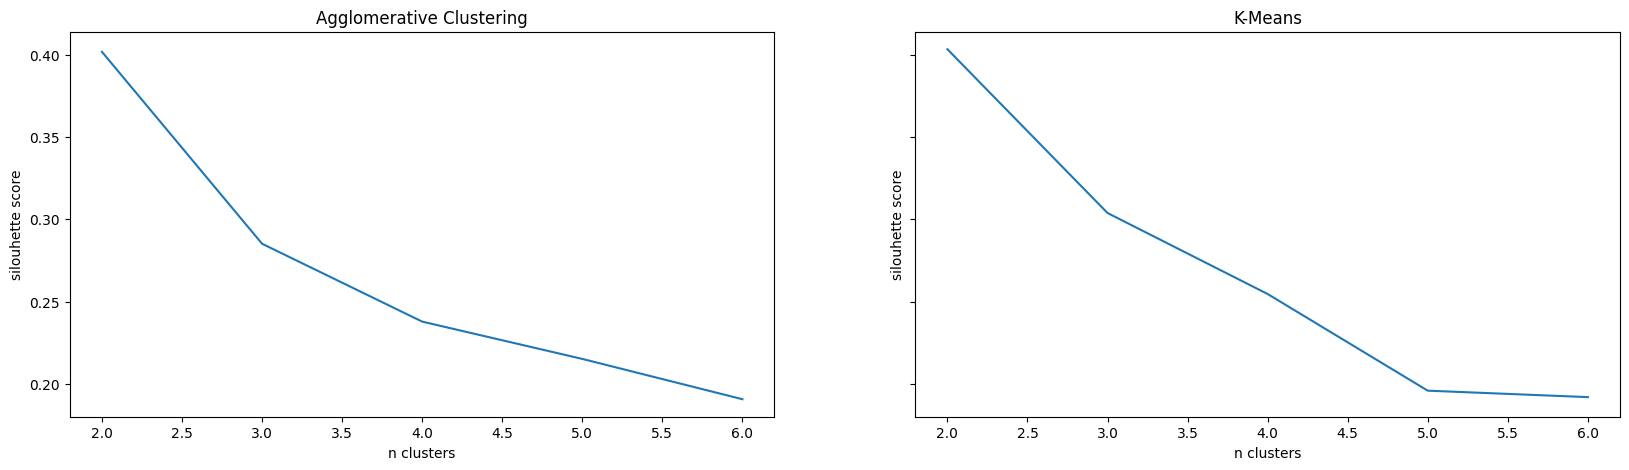

In [231]:
def calcular_silhouette(x: npt.NDArray[np.float32]):
    type ArrayOfAxes = npt.NDArray[plt.Axes]
    _, axs = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
    n_clusters = range(2, 7)
    methods = {"Agglomerative Clustering": cluster_ac, "K-Means": cluster_kmeans}
    for ax, title, method in zip(axs, methods.keys(), methods.values()):
        res = [silhouette_score(x, method(x, c)) for c in n_clusters]
        ax.plot(n_clusters, res)
        ax.set_xlabel("n clusters")
        ax.set_ylabel("silouhette score")
        ax.set_title(title)


calcular_silhouette(x)

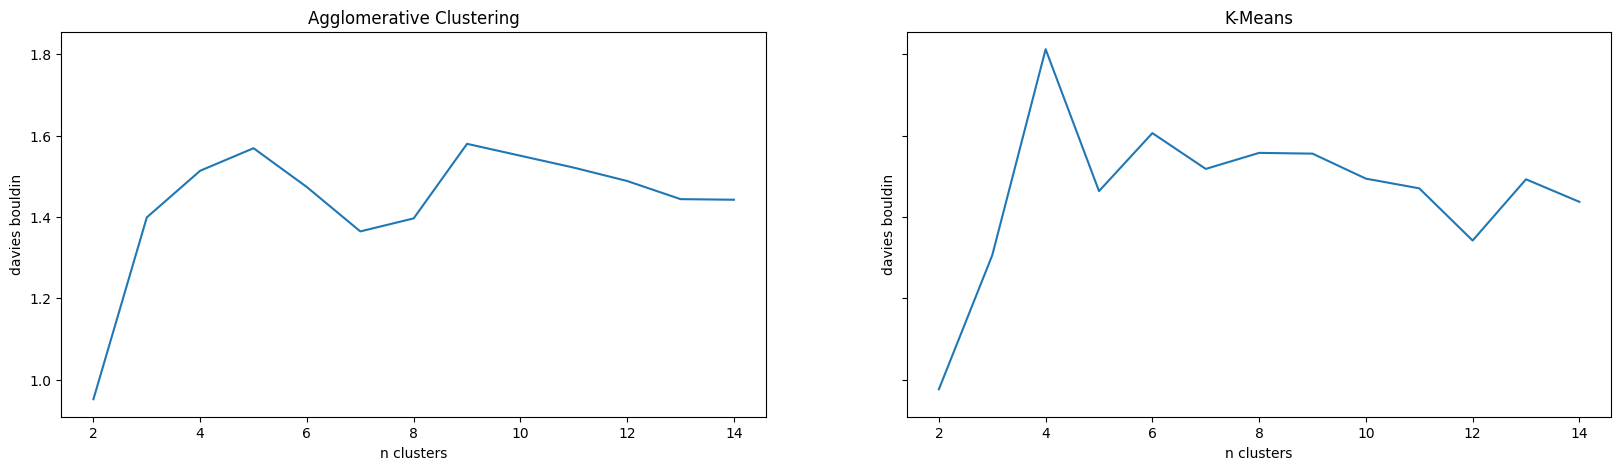

In [232]:
def calcular_davies_bouldin(x: np.ndarray):
    _, ax = plt.subplots(1, 2, figsize=(20, 5), sharey=True)

    methodos = [cluster_ac, cluster_kmeans]
    for i, m in enumerate(methodos):
        res = []
        for c in range(2, 15):
            res += [davies_bouldin_score(x, m(x, c))]

        ax[i].plot(range(2, 15), res)
        ax[i].set_xlabel("n clusters")
        ax[i].set_ylabel("davies bouldin")
        ax[i].set_title("Agglomerative Clustering" if i == 0 else "K-Means")


calcular_davies_bouldin(x)

## 2.2 ¿Qué número de clusters elegiría y por que?

## 2.3 Mostrar resultados (ejecute el código a continuación)

In [233]:
def reducir_dim(x, ndim):
    pca = PCA(n_components=ndim)
    return pca.fit_transform(x)


def reducir_dim_tsne(x, ndim):
    pca = TSNE(n_components=ndim)
    return pca.fit_transform(x)


def reducir_dataset(x, how="original"):
    if how == "pca":
        res = reducir_dim(x, ndim=2)
    elif how == "tsne":
        res = reducir_dim_tsne(x, ndim=2)
    else:
        res = x[:, :2]

    return res


# se ejecutan algoritmos de clusterings con la configuración que le parezca más idónea
clus_ac = cluster_ac(x, 4)
clus_km = cluster_kmeans(x, 4)
clus_db = cluster_dbscan(x)

# se reducen las dimensiones de los datos originales para poder mostrar en pantalla
# x_red = reducir_dim(x, 2)
# x_red = reducir_dim_tsne(x, 2)
# x_red = x[:, :2]

# se concatenan los resultados en un dataframe
results = pd.DataFrame(
    np.column_stack([reducir_dataset(x, how="original"), clusters, clus_ac, clus_km, clus_db]),
    columns=["x", "y", "clusters", "clus_ac", "clus_km", "clus_db"],
)

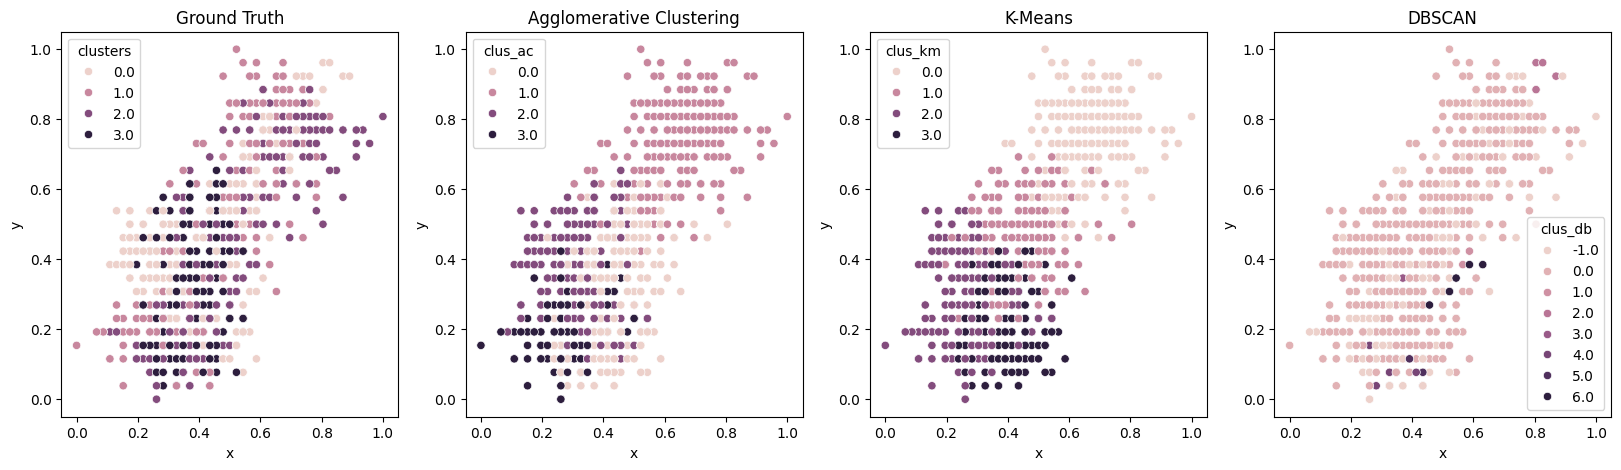

In [234]:
def mostrar_resultados(res):
    """Muestra los resultados de los algoritmos"""
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    sns.scatterplot(data=res, x="x", y="y", hue="clusters", ax=ax[0], legend="full")
    ax[0].set_title("Ground Truth")
    sns.scatterplot(data=res, x="x", y="y", hue="clus_ac", ax=ax[1], legend="full")
    ax[1].set_title("Agglomerative Clustering")
    sns.scatterplot(data=res, x="x", y="y", hue="clus_km", ax=ax[2], legend="full")
    ax[2].set_title("K-Means")
    sns.scatterplot(data=res, x="x", y="y", hue="clus_db", ax=ax[3], legend="full")
    ax[3].set_title("DBSCAN")


mostrar_resultados(results)

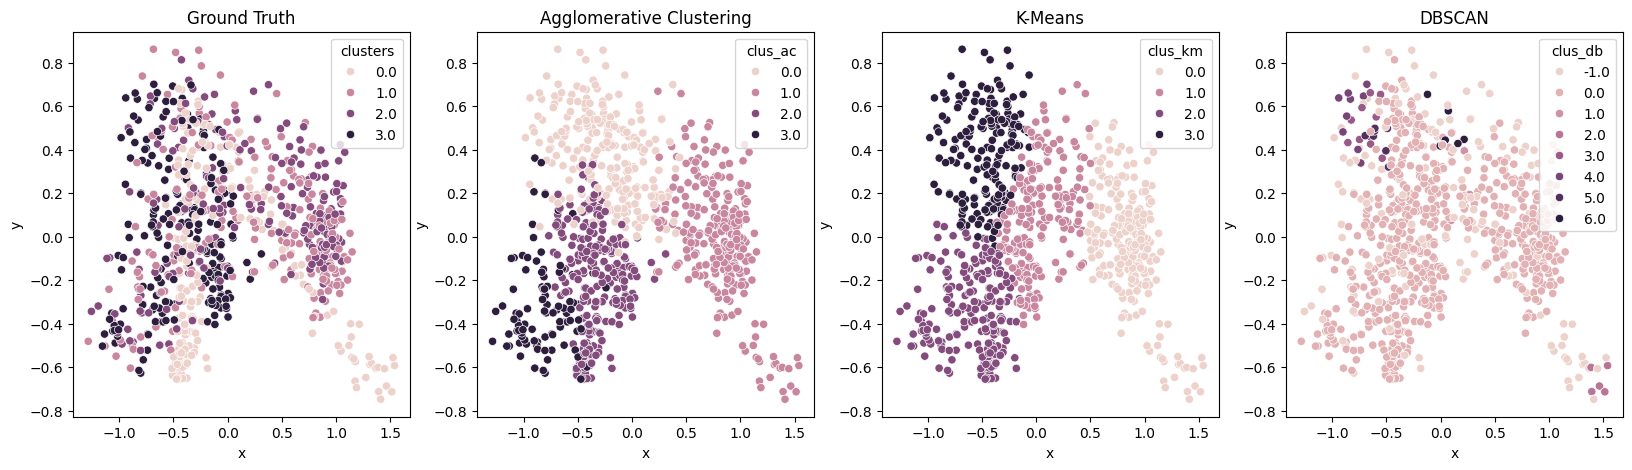

In [235]:
# se concatenan los resultados en un dataframe
results = pd.DataFrame(
    np.column_stack([reducir_dataset(x, how="pca"), clusters, clus_ac, clus_km, clus_db]),
    columns=["x", "y", "clusters", "clus_ac", "clus_km", "clus_db"],
)

mostrar_resultados(results)

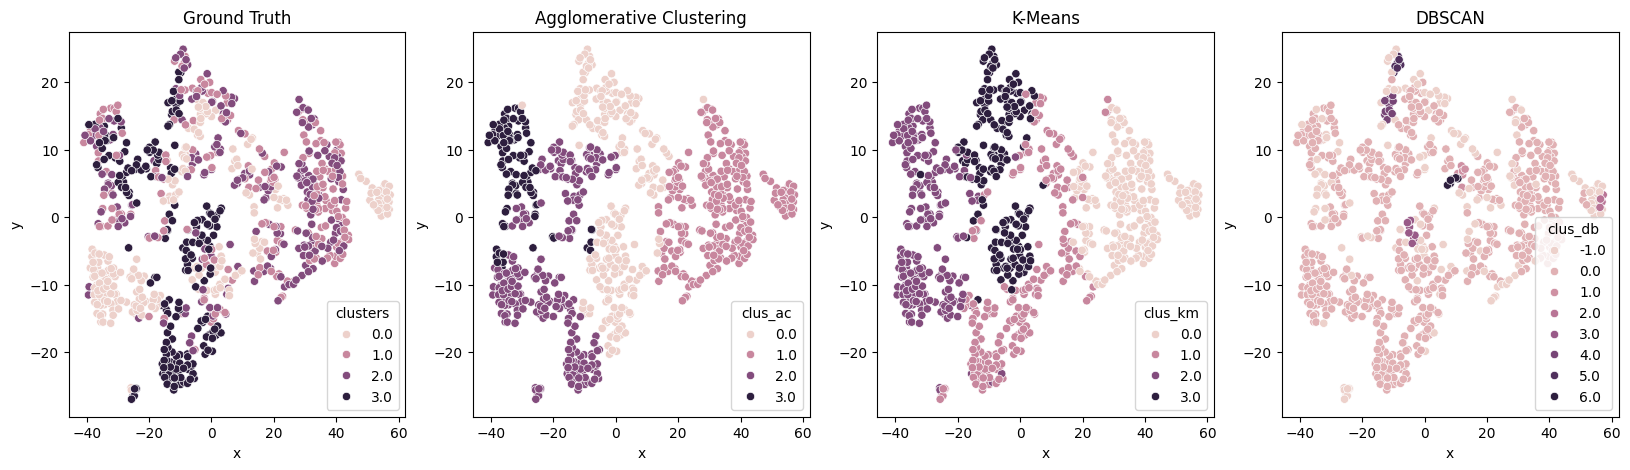

In [236]:
# se concatenan los resultados en un dataframe
results = pd.DataFrame(
    np.column_stack([reducir_dataset(x, how="tsne"), clusters, clus_ac, clus_km, clus_db]),
    columns=["x", "y", "clusters", "clus_ac", "clus_km", "clus_db"],
)

mostrar_resultados(results)

## 2.4 Analizando los resultados gráficos

comparando el gráfico con las clas clases orignales del problema ("ground truth") y las particiones obtenidas por los algoritmos de clustering, ¿Se pudieron recrear las particiones iniciales?

¿Por que si, o por que no?

## 2.5 Analizando los clusters

Ejecute el siguiente código y analice los resultados. Los gráficos de coordenadas paralelas revelan valores de las variables con una codificación de colores en base, en este caso, del cluster encontrado

<Axes: >

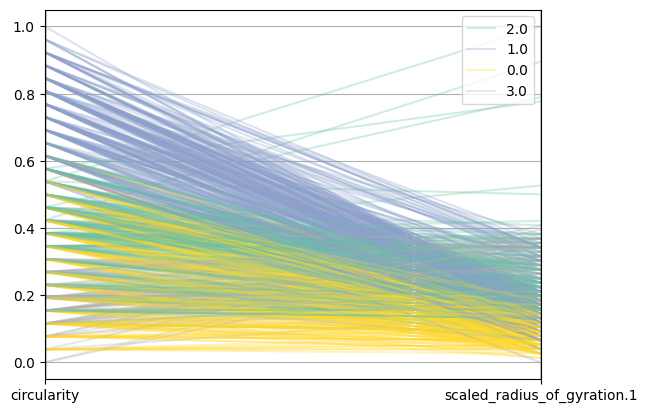

In [237]:
def crear_ds_cluster(datos, etiquetas):
    ds = np.column_stack([datos, etiquetas])
    return pd.DataFrame(ds)


ds_cluster = crear_ds_cluster(x, cluster_ac(x, 4))

ds_cluster.columns = list(df.columns)[:-1] + ["cluster"]
parallel_coordinates(ds_cluster.iloc[:, [1, 13, -1]], "cluster", colormap=plt.get_cmap("Set2"), alpha=0.3)

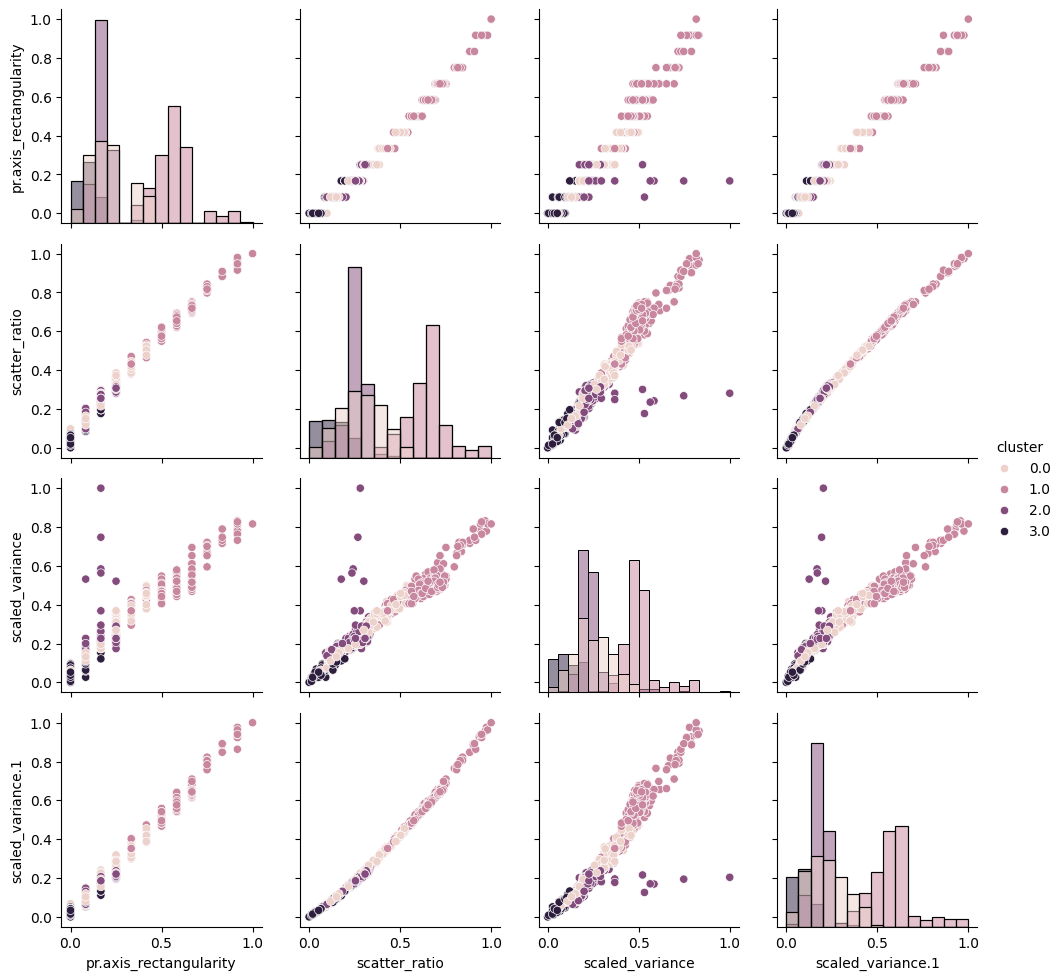

In [238]:
g = sns.PairGrid(ds_cluster.iloc[:, [8, 6, 10, 11, -1]], hue="cluster")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()


## 2.6 Analice los clusters

Pruebe manualmente distintas variables para generar el gráfico de coordenadas paralelas y el de pares. Responda las siguientes preguntas:

- ¿Que variables ayudan a caracterizar de mejor manera algún cluster?
- ¿Que variables son las mejores para hacer este análisis?
- ¿Que tan práctico es hacer este análisis si el problema tiene más dimensiones, por ejemplo > 30?

In [239]:
# inserte su código aquí



Con las variables que considere más representativas, calcule valores estadísticos como promedios, mínimos, máximos, etc. Ahora intente ponerle un nombre a cada cluster.

In [240]:
# inserte su código aquí


## 2.7 Encuentre las variables importantes mediante técnicas de clasificación

Use la variable `ds_cluster` y entrene un modelo Random Forest, usando la columna `cluster` como variable de clasificación. Averigue como encontrar las variables más informativas de este modelo y use las que considere más representativas para repetir el análisis del ejercicio anterior.

¿Las variables que encontró manualmente son las mismas que las que encontró Random Forest?

In [244]:
# inserte su código aquí
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    results.drop(columns=["class"]),
    results[-1],
    test_size=0.25,
    random_state=123,
)

# Creación del modelo
# ==============================================================================
modelo = RandomForestRegressor(
    n_estimators=10,
    criterion="squared_error",
    max_depth=None,
    max_features=1,
    oob_score=False,
    n_jobs=-1,
    random_state=123,
)

# Entrenamiento del modelo
# ==============================================================================
modelo.fit(X_train, y_train)

# Error de test del modelo inicial
# ==============================================================================
predicciones = modelo.predict(X=X_test)
rmse = mean_squared_error(y_true=y_test, y_pred=predicciones)
print(f"El error (rmse) de test es: {rmse}")


KeyError: "['class'] not found in axis"